In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy

import colossus
import colossus.cosmology
import colossus.cosmology.cosmology as cosmo
import colossus.halo
import colossus.halo.mass_so as halo_mass
import colossus.halo.concentration as halo_concentration

#from colossus.cosmology import cosmology
#from colossus.halo.mass_so import M_to_R
#from colossus.halo.concentration import concentration

from astropy import constants as const
from astropy import units as u
from astropy import coordinates as coord
from astropy.cosmology import FlatLambdaCDM

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
import sys
sys.path.append("/home/user/Physik_Bonn/research_project")

from codes.map_creation import map_maker, lens_profile
from codes.lensing import lensing

# Random gaussian field creation

## Code

In [2]:
map_size = 2 #arcminutes
pixel_size = 1/2 #arcseconds

pixel_number = map_size*(60/pixel_size)

x = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
y = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

l = np.arange(30000, dtype=float)
const = 10
index = -0.7

spectrum=const*(l**index)
spectrum[0] = 0

/tmp/ipykernel_12563/319828132.py:15: RuntimeWarning: divide by zero encountered in power
  spectrum=const*(l**index)


In [3]:
fs_scale_factor = np.pi/(pixel_size/60 * np.pi/180)
R_fs = R*fs_scale_factor
print(R_fs.astype(int))

spectrum_map = np.zeros(int(R_fs.max())+1)

spectrum_map[0:spectrum.size] = spectrum

spectrum_map_confined = spectrum_map[(R_fs).astype(int)]
print(spectrum_map.shape)
print(spectrum_map_confined.shape)
print(240*240)

[[30547 30419 30292 ... 30292 30419 30547]
 [30419 30291 30163 ... 30163 30291 30419]
 [30292 30163 30035 ... 30035 30163 30292]
 ...
 [30292 30163 30035 ... 30035 30163 30292]
 [30419 30291 30163 ... 30163 30291 30419]
 [30547 30419 30292 ... 30292 30419 30547]]
(30548,)
(240, 240)
57600


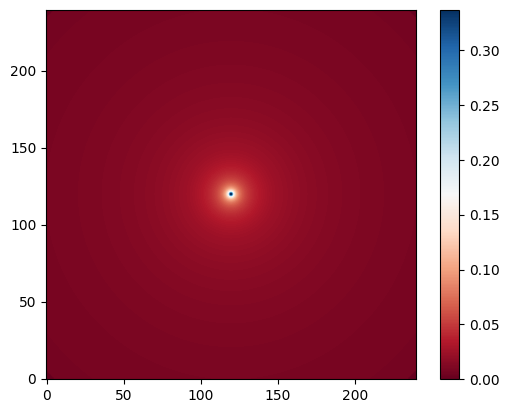

In [4]:
im = plt.imshow(spectrum_map_confined, interpolation='bilinear', origin='lower', cmap='RdBu')
#im.set_clim(0,spectrum_map_confined.max()/4)
cbar = plt.colorbar()
plt.show()

In [5]:
random_noise_2d = np.random.normal(0, 1, (int(pixel_number), int(pixel_number)))
random_noise_2d_fs = np.fft.fft2(random_noise_2d)

signal_map_fs = spectrum_map_confined*random_noise_2d_fs

signal_map = np.fft.ifft2(np.fft.fftshift(signal_map_fs))

In [6]:
#signal_map = np.fft.ifft2(signal_map_fs)
signal_map = signal_map / fs_scale_factor
signal_map = np.real(signal_map)

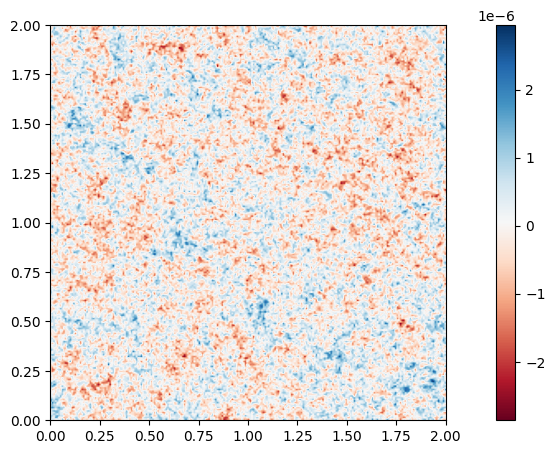

In [83]:
im = plt.imshow(signal_map, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim()
X_width = pixel_number*pixel_size/60.  # horizontal map width in degrees
Y_width = pixel_number*pixel_size/60.  # vertical map width in degrees

plt.gcf().set_size_inches(6,6)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.show()

In [72]:
signal_map.max()

np.float64(2.9528164047595824e-06)

## Class

In [74]:
class missing_variable_error(Exception):
    """raised when necessary variables are not given"""
    def __init__(self, variable_name: str):
        super().__init__(f"{variable_name} has not been specified. Please provide a value.")
    
class missing_spectrum_type_error(Exception):
    """raised when spectrum type is not given"""
    def __init__(self):
        super().__init__(f"Spectrum type has not been specified. Please provide a type.")

class map_maker():
    def __init__(self, map_size: int = None, pixel_size: float = None, pixel_number: int = None, l_degrees: int = None, const: float = 1, index: float = -1, spectrum_type: str = "power law"):
        ## external variables
        self.map_size = map_size
        self.pixel_size = pixel_size
        self.pixel_number = pixel_number
        self.l_degrees = l_degrees
        self.const = const
        self.index = index
        self.spectrum_type = spectrum_type
        ## internal variables
        self.spectrum = None                       # unless loaded in

        self.X = None
        self.Y = None
        self.X_fs = None
        self.Y_fs = None

        self.X_scaled = None
        self.Y_scaled = None
        self.X_fs_scaled = None
        self.Y_fs_scaled = None

        self.R = None
        self.R_scaled = None
        self.R_check = False
        self.fs_scale_factor = None
        self.R_fs = None
        self.R_fs_scaled = None
        self.R_fs_check = False
        self.random_noise_2d = None
        self.random_noise_2d_fs = None
        ## output variables
        self.grf_fs = None
        self.grf = None
        self.rms = None

    def set_map_variables(self, map_size = None, pixel_size = None, pixel_number = None) -> bool:
        if map_size is not None:
            self.map_size = map_size
        if pixel_size is not None:
            self.pixel_size = pixel_size
        if pixel_number is not None:
            self.pixel_number = pixel_number
        else:
            self.pixel_number = self.map_size/(self.pixel_size)
        if not all((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing map_variables.")
            return False
        else:
            print("Full set of map variables defined.")
            print("Map Size: " + str(self.map_size) + "\n"
                  + "Pixel Size: " + str(self.pixel_size) + "\n"
                  + "Number of Pixel: " + str(self.pixel_number))
            return True

    def make_map_coordinates(self, map_size = None, pixel_size = None, pixel_number = None):
        
        if any((map_size, pixel_size, pixel_number)) or self.pixel_number is None:
            self.set_map_variables(map_size, pixel_size, pixel_number)
        x = np.linspace(-0.5*self.map_size, 0.5*self.map_size, int(self.pixel_number))
        y = np.linspace(-0.5*self.map_size, 0.5*self.map_size, int(self.pixel_number))
        X, Y = np.meshgrid(x, y, sparse=True)           ## TODO: check if sparse works correctly
        self.R = np.sqrt(X**2 + Y**2)
        self.R_check = True
        print("coordinates made.")
        self.X = X
        self.Y = Y

        return None
    
    def make_fourier_map_coordinates(self) -> None:
        self._compute_fourierSpace_scaler()
        #pixel_size_fs = (np.pi/180)*(self.pixel_size/60.)
        #x_fs = 2*np.pi(np.fft.fftfreq(self.pixel_number, pixel_size_fs))
        #y_fs = 2*np.pi(np.fft.fftfreq(self.pixel_number, pixel_size_fs))
        pixel_size_fs = 2*np.pi*self.fs_scale_factor
        x_fs = 2*np.pi(np.fft.fftfreq(self.pixel_number, pixel_size_fs))
        y_fs = 2*np.pi(np.fft.fftfreq(self.pixel_number, pixel_size_fs))
        #x_fs_min, x_fs_max = min(x_fs), max(x_fs)
        #y_fs_min, y_fs_max = min(y_fs), max(y_fs)
        X_fs, Y_fs = np.meshgrid(x_fs, y_fs)
        self.X_fs, self.Y_fs = X_fs, Y_fs
        return None
    
    def normalize_coordinates(self, X: list[float] = None, Y: list[float] = None, Fourier=False) -> None:
        
        if Fourier:
            self.X_fs_scaled = self.X/(max(self.X)-min(self.X))
            self.Y_fs_scaled = self.Y/(max(self.Y)-min(self.Y))
            self.R_fs_scaled = np.sqrt(self.X_fs_scaled**2 + self.Y_fs_scaled**2)
        else:
            self.X_scaled = self.X/(max(self.X[0])-min(self.X[0]))
            self.Y_scaled = self.Y/(max(self.Y)-min(self.Y))
            
            self.R_scaled = np.sqrt(self.X_scaled**2 + self.Y_scaled**2)
        print("Normalized Coordinates set.")
        return None

    
    def _compute_fourierSpace_scaler(self) -> float:
        if self.pixel_size is None:
            raise missing_variable_error("pixel_size")
        fs_scale_factor = (self.pixel_size/60 * np.pi/180)
        #fs_scale_factor = 2*np.pi*(self.pixel_size/60) * (np.pi/180)            ## TODO: Check if aarcmin/arcsec conversion is correct here
        self.fs_scale_factor = fs_scale_factor
        return fs_scale_factor
    
    def _R_fourierSpace_mapping(self) -> list[float]:
        scale = self._compute_fourierSpace_scaler()
        R_fs = self.R*scale
        self.R_fs = R_fs
        self.R_fs_check = True
        return R_fs
    
    def set_spectrum_variables(self, l_degrees: int = None, const:float = None, index: float = None) -> bool:
        if l_degrees is not None:
            print(l_degrees)
            self.l_degrees = l_degrees
            print(self.l_degrees)
        if const is not None:
            self.const = const
        if index is not None:
            self.index = index
        if not any((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing variables for the spectrum (power-law).")
            return False
        else:
            print("Full set of variables for the spectrum (power-law) defined.")
            return True

    def make_spectrum(self, const: float = None, l_degrees: int = None, index: float = None, zero_dipole=False, spectrum_type: str = None,) -> None:
            
        self.set_spectrum_variables(const, l_degrees, index)
        l = np.arange(2, self.l_degrees, dtype=float)
        if spectrum_type:
            self.spectrum_type = spectrum_type
        if self.spectrum_type == "power law":
            spectrum=self.const*(l**self.index)
        if self.spectrum_type == "acoustic":
            print("Used Spectrum type acoustic.")
            Dl = 6000 * (l / 200.)**(-1) * (1 + 0.5 * np.sin(l / 200. - 2) * np.exp(-(l - 200)**2 / 50000))
            spectrum = Dl * 2 * np.pi / (l * ( + 1.))
        else:
            raise missing_spectrum_type_error()
        spectrum[0] = 0
        if zero_dipole:
            spectrum[1] = 0
            spectrum[2] = 0
            spectrum[3] = 0
        self.spectrum = spectrum

        return None
    
    def load_spectrum(self, path: str) -> None:
        """ 
            Spectrum different than a power law? Here you go...
            TODO: All of it ...
        """
        return None
    
    def make_spectrum_map(self, spectrum_path: str = None, const: float = None, l_degrees: int = None, index: float = None, zero_dipole = False, spectrum_type = "power law") -> None:
        """ 
            Creates a map of the spectrum (Inside Fourier Space) as well as a cut version leaving out areas of null values.
            TODO: add option to intervene in scale

        """
        self.normalize_coordinates()
        if spectrum_path is not None:
            self.load_spectrum(self, spectrum_path)
        elif any((const, l_degrees, index)) or self.spectrum is None:
            self.make_spectrum(const, l_degrees, index, zero_dipole, spectrum_type)

        multipole_field = self.R_scaled * np.pi / self.fs_scale_factor

        spectrum_map_complete = np.zeros(int(multipole_field.max())+1)
        print(spectrum_map_complete.size)
        spectrum_map_complete[0:self.spectrum.size] = self.spectrum

        # if self.R_fs is None:
        #     raise missing_variable_error("R_fs")

        spectrum_map_confined = spectrum_map_complete[multipole_field.astype(int)]
        self.spectrum_map_complete = spectrum_map_complete
        self.spectrum_map_confined = spectrum_map_confined
        return None

    def _make_random_noise(self, N: int = None) -> None:
        if N is not None:
            self.pixel_number = N
        self.random_noise_2d = np.random.normal(0, 1, (int(self.pixel_number), int(self.pixel_number)))
        self.random_noise_2d_fs = np.fft.fft2(self.random_noise_2d)
        return None

    def make_gaussian_random_field(self, zero_dipole = False, spectrum_type: str = "power law") -> list[float]:
        
        if not self.R_check:
            self.make_map_coordinates()
        if not self.R_fs_check:  
            self._R_fourierSpace_mapping()
        self.make_spectrum_map(zero_dipole=zero_dipole, spectrum_type=spectrum_type)
        self._make_random_noise()

        self.grf_fs = np.sqrt(self.spectrum_map_confined)*self.random_noise_2d_fs              ## gaussian-random-field in Fourier-Space

        self.grf = np.fft.ifft2(np.fft.fftshift(self.grf_fs)) / self.fs_scale_factor      ## gaussian-random-field after inverse fft2

        self.grf_real = np.real(np.fft.ifft2(np.fft.fftshift(self.grf_fs))) / self.fs_scale_factor
        
        return self.grf_fs, self.grf, self.grf_real
    
    def plot_gaussian_random_field(self) -> None:
        im = plt.imshow(self.grf_real, origin='lower', interpolation='bilinear', cmap='RdBu')
        im.set_clim()

        plt.xlabel(r"$\theta_x$[arcmin]")
        plt.ylabel(r"$\theta_y$[arcmin]")

        cbar = plt.colorbar(im)
        cbar.set_label("T [K]")   # label for the scale
        return None
    
    def rms_estimation(self) -> float:
        self.rms = np.sqrt(np.mean(self.grf_real**2))
        return self.rms

## Test

Full set of map variables defined.
Map Size: 120
Pixel Size: 0.1667
Number of Pixel: 719.8560287942412
coordinates made.
##############################
4.849106438457578e-05
tttttttttttttttttttttttttttttt
[[-1.         -0.99721448 -0.99442897 -0.99164345 -0.98885794 -0.98607242
  -0.98328691 -0.98050139 -0.97771588 -0.97493036 -0.97214485 -0.96935933
  -0.96657382 -0.9637883  -0.96100279 -0.95821727 -0.95543175 -0.95264624
  -0.94986072 -0.94707521 -0.94428969 -0.94150418 -0.93871866 -0.93593315
  -0.93314763 -0.93036212 -0.9275766  -0.92479109 -0.92200557 -0.91922006
  -0.91643454 -0.91364903 -0.91086351 -0.90807799 -0.90529248 -0.90250696
  -0.89972145 -0.89693593 -0.89415042 -0.8913649  -0.88857939 -0.88579387
  -0.88300836 -0.88022284 -0.87743733 -0.87465181 -0.8718663  -0.86908078
  -0.86629526 -0.86350975 -0.86072423 -0.85793872 -0.8551532  -0.85236769
  -0.84958217 -0.84679666 -0.84401114 -0.84122563 -0.83844011 -0.8356546
  -0.83286908 -0.83008357 -0.82729805 -0.82451253 -0.821

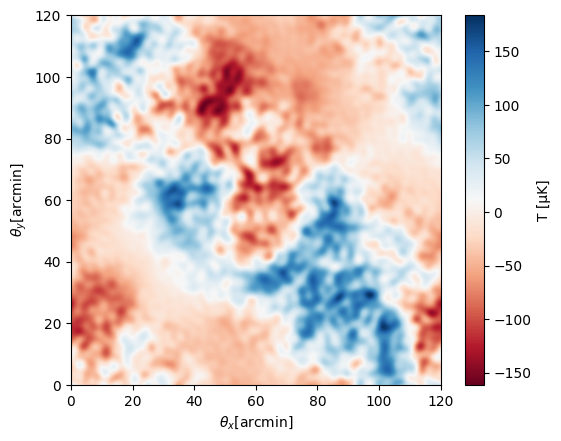

In [14]:
test1 = map_maker(map_size=120, pixel_size=0.1667, l_degrees=6000)
test1_map_fs, test1_map, test1_map_real = test1.make_gaussian_random_field(zero_dipole=True, spectrum_type = "acoustic")
test1.plot_gaussian_random_field()
print(test1.rms_estimation())

In [15]:
print(test1_map_real.max())
print(test1_map_real.min())

183.62365281061804
-161.32174826731986


In [8]:
test1 = map_maker(map_size=2, pixel_size=0.5, l_degrees=3000, const=3e-3, index=-1)
test1_map_fs, test1_map, test1_map_real = test1.make_gaussian_random_field()
test1.plot_gaussian_random_field()
print(test1.rms_estimation())

Full set of map variables defined.
Map Size: 2
Pixel Size: 0.5
Number of Pixel: 4.0
coordinates made.
##############################
0.0001454441043328608
tttttttttttttttttttttttttttttt
[[-1.         -0.33333333  0.33333333  1.        ]]
2.0
ääääääääääääääääääääääääää
[[1.41421356 1.05409255 1.05409255 1.41421356]
 [1.05409255 0.47140452 0.47140452 1.05409255]
 [1.05409255 0.47140452 0.47140452 1.05409255]
 [1.41421356 1.05409255 1.05409255 1.41421356]]
Normalized Coordinates set.
Full set of variables for the spectrum (power-law) defined.


missing_spectrum_type_error: Spectrum type has not been specified. Please provide a type.

# lens profile

## code

In [3]:
from codes.map_creation import nfw_lens
h = 0.6774
omega_m = 0.3089
lens = nfw_lens(cosmology = FlatLambdaCDM(H0=h*100., Om0=omega_m))

In [5]:
lens.make_map(120, 0.1667)
lens._calc_angular_seperation()
lens._calc_ref_density()
lens._calc_virial_r()
cosmo.setCosmology("planck15")
lens._calc_concentration()
lens._calc_nfwConcentration()
lens._calc_nfwScaleRadius()
lens._calc_lensing_distances()
lens._calc_crit_surface_density()
lens._calc_pyhsical_dist()
lens._calc_nfwProfile()
lens.proj_surf_density()
lens.kappa()
lens._make_multipole_magnitude_2d(120, 0.1667)
lens.kappa2alpha()

# alpha = np.array([lens.alphaX, lens.alphaY])
# alpha

719
120
77777777777777777777777777777777777
[[ 0.00011684  0.00035042  0.00058385 ... -0.00058385 -0.00035042
  -0.00011684]
 [ 0.00011684  0.00035044  0.00058389 ... -0.00058389 -0.00035044
  -0.00011684]
 [ 0.00011686  0.00035049  0.00058396 ... -0.00058396 -0.00035049
  -0.00011686]
 ...
 [ 0.00011686  0.00035049  0.00058396 ... -0.00058396 -0.00035049
  -0.00011686]
 [ 0.00011684  0.00035044  0.00058389 ... -0.00058389 -0.00035044
  -0.00011684]
 [ 0.00011684  0.00035042  0.00058385 ... -0.00058385 -0.00035042
  -0.00011684]]


In [ ]:
1489393125964340.2
1489393125964340.2

In [9]:
alpha = np.array([lens.alphaX, lens.alphaY])
alpha

array([[[-2.17413656e-49, -9.87894320e-49, -8.44913808e-49, ...,
          1.12766237e-48,  6.40444988e-49,  1.82225188e-49],
        [-7.52544285e-49, -6.64950250e-49, -1.81075866e-48, ...,
          1.10437564e-48,  5.67493370e-49,  3.53680473e-49],
        [-1.94280901e-49, -1.69715377e-48, -1.07469641e-48, ...,
          9.11458960e-49,  9.67648463e-49, -2.55002594e-49],
        ...,
        [ 2.55002594e-49, -9.67648463e-49, -9.11458960e-49, ...,
          1.07469641e-48,  1.69715377e-48,  1.94280901e-49],
        [-3.53680473e-49, -5.67493370e-49, -1.10437564e-48, ...,
          1.81075866e-48,  6.64950250e-49,  7.52544285e-49],
        [-1.82225188e-49, -6.40444988e-49, -1.12766237e-48, ...,
          8.44913808e-49,  9.87894320e-49,  2.17413656e-49]],

       [[-2.17413656e-49, -7.52544285e-49, -1.94280901e-49, ...,
          2.55002594e-49, -3.53680473e-49, -1.82225188e-49],
        [-9.87894320e-49, -6.64950250e-49, -1.69715377e-48, ...,
         -9.67648463e-49, -5.67493370e

In [ ]:
# cluster parameters

cluster_mass = 5e14
cluster_redshift = 0.7
omega_m = 0.3089
omega_l = 0.6911
G = 4.30091 * 10**(-3) / (10**(6))

def scaler_expansion(omega_m, omega_l, a):
    return 1/np.sqrt(a * omega_m + a**4 * omega_l)


In [ ]:
cosmo.setCosmology("planck18")

def calc_comoving_dist(z, H_zero, omega_m, omega_l):
    return (c * H_zero) * scipy.integrate.quad(scaler_expansion(), np.power(1+z, -1), 1, args = (omega_m, omega_l))[0]


def r_x(m, z, h):
    """
        h = scaled Hubble
    """
    return halo_mass.M_to_R(m, z, "200c") * h /10**3

def c_x(m, z):
    """ 
    """
    return halo_concentration.concentration(m, "200c", z, model = 'diemer15')

def calc_Hubble_parameter(z, H_zero):
    return np.sqrt( H_zero**2 * ((1+z)**3 * omega_m + omega_l ))

def calc_rho_crit(z):
    G = 4.30091 * 10**(-3) / (10**(6))
    return (3 * calc_Hubble_parameter(z)**2) / (8 * np.pi * G)

def density_parameter(m, z):
    c_200 = c_x(m, z)
    return (200/3) * calc_rho_crit(z)

def rho_NFW(r, M_200, z):
    """ 
        NFW Density profile in ((M_(solar))/(Mpc**(-3)))
        Input:  - r: float =        
                - M_200: float =    
                - z: float =        
        Return: 
    """
    # scale radius R_s [Mpc]
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    # density parameter 
    density_para = density_parameter(M_200, z)
    return density_para / ((r/R_s)*(1 + (r/R_s))**2)
 
def M_NFW(r, M_200, z):
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    return  4 * np.pi * density_parameter(M_200, z) * np.power(R_s, 3) * (np.log((R_s + r)/R_s) - (r/(R_s + r)))

In [10]:
rho_NFW(2, 2, 2)

np.float64(1.3551912813969275e-06)

In [11]:
M_NFW(2, 2, 2)

np.float64(0.0019292414150759913)

In [ ]:
def calc_lambda(angle, M_200, z):
    x_1 = calc_comov_dist(z)
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    return x_1 * angle / ((1+z) * R_s)

def calc_f(angle, m, z):
    lmb = calc_lambda(angle, m, z)

    f = n.zeros(np.shape(angle))
    for i in range(np.shape(f)[0]):
        for j in range(np.shape(f)[1]):
            if lmb[i][j] > 1:
                f[i][j] = (3.23 / lmb[i][j]) * (np.log(lmb[i][j]/2)) + np.log(lmb[i][j]/(1 - np.sqrt(1 - lmb[i][j]**2))) / np.sqrt(1 - lmb[i][j]**2)
            elif lmb[i][j] < 1:
                f[i][j] = (3.23 / lmb[i][j]) * (np.log(lmb[i][j]/2) + (np.pi/2 - np.arcsin(1/lmb[i][j]) ) / np.sqrt(lmb[i][j]**2 - 1) )
            else:
                print("lmb = " + str(lmb[i][j]) + "lmb will be calculated as if smaller than 1")
    return f

def calc_v_max(m, z):
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    return 0.46 * np.sqrt(4 * np.pi * G * density_parameter * R_s**2)

def d_theta(r, m, z):
    theta = r/calc_comoving_dist(z, H_zero, omega_m, omega_l)
    return 0.54 * (calc_v_max(m, z))**2 * (calc_comoving_dist(z, H_zero, omega_m, omega_l) - calc_comoving_dist(1100.0, H_zero, omega_m, omega_l)) * (calc_f(theta, m, z) / calc_comoving_dist(1100.0, H_zero, omega_m, omega_l))


## class

In [36]:
class missing_internal_variable_error(Exception):
    """raised when necessary variables are calculated"""
    def __init__(self, variable_name: str):
        super().__init__(f"{variable_name} has not been calculated. Please first calculate {variable_name}.")

class lens_profile():
    """ 
        class is mostly reused/cleaned code from Awais Mirza 2019 at Argelander Institut Bonn

        lens is presumed to be NFW
    """

    ## TODO: Decide on wether positions should be in angular position (2d) or in radial distance from the center (radial symmetry)

    def __init__(self, cluster_mass = 5e14, cluster_redshift = 0.7, r_max = 10, hubble_constant = 67.74, cosmology = "planck18", omega_m = 0.3089, omega_l = 0.6911, grav_constant = 4.30091 * 10**(-3) / (10**(6)), speed_of_light = scipy.constants.speed_of_light):
        ## cluster parameters
        self.M = cluster_mass
        self.z = cluster_redshift
        ## physics
        self.c = speed_of_light
        self.G = grav_constant
        self.cosmology = cosmology
        self.omega_m = omega_m
        self.omega_l = omega_l
        self.h_zero = hubble_constant/100 ## automatically scaled
        ## internal parameters
        self.hubble_parameter_factor = None
        self.hubble_parameter = None
        self.comoving_dist = None
        self.r_x = None
        self.c_x = None
        self.rho_crit = None
        self.r_s = None
        self.density_parameter = None

        self.lmb = None
        self.f = None
        self.v_max = None
        ## space variables
        #self.r_max = r_max ## in Mpc
        #self.r_min = 0.1 ## not usually changed
        self.rSpace = None

        self.n = 100

        self.pos_map = None
        ## output
        self.M_nfw = None
        self.rhoLens = None
        self.v_max = None
        self.d_theta = None

        print("cluster mass " + str(self.M) +"\n"
                + "cluster redshift z: " + str(self.z) + "\n"
                + "speed of light: " + str(self.c) + "\n"
                + "scaled hubble constant: " + str(self.h_zero) + "\n"
                + "omega_m: " + str(self.omega_m) + "\n"
                + "omega_l: " + str(self.omega_l) + "\n"
                + "cosmology: " + str(self.cosmology))

        print("############################################")
        
        self._calc_hubble_parameter_factor()

        self.set_angle_map(3, self.n)

        self._calc_comoving_dist()
        self.set_rSpace()

        cosmo.setCosmology(self.cosmology)
        print("Cosmology set as " + self.cosmology)
        return None

    def set_rMax(self, r_max: float) -> None:
        self.r_max = r_max
        return None
    
    def set_rMin(self, r_min: float) -> None:
        self.r_min = r_min
        return None

    def set_angle_map(self, theta_max: float, n: int):
        """       
            so far exclusively squared maps centered at zero
        """
        self.n = n

        dec = np.linspace(-theta_max, theta_max, n)
        asc = np.linspace(theta_max, -theta_max, n)

        pos_map = np.meshgrid(dec, asc)
        self.pos_map = np.array(pos_map)
        print('pos map set!')
        return self.pos_map

    def set_rSpace(self) -> None:  ### naming dist_map
        dx = np.tan(np.max(self.pos_map[0])-np.min(self.pos_map[0])/testLens1.pos_map.shape[1]) * self.comoving_dist
        dy = dx = np.tan(np.max(self.pos_map[1])-np.min(self.pos_map[1])/testLens1.pos_map.shape[2]) * self.comoving_dist

        n = self.n
        x = np.linspace(-n/2, n/2, n) * dx
        y = np.linspace(-n/2, n/2, n) * dy

        X, Y = np.meshgrid(x, y)

        self.rSpace = np.sqrt(X**2 + Y**2)
        return None

    # def set_rSpace(self, r_min: float = 0.1, r_max: float = None, N: int = 100) -> None:
    #     if r_max:
    #         self.set_rMax(r_max)
    #     if r_min:
    #         self.set_rMin(r_min)
    #     self.rSpace = np.linspace(self.r_min, self.r_max, N)
    #     print("rSpace set!")
    #     return None

    def _calc_hubble_parameter_factor(self, omega_m: float = None, omega_l: float = None, z: float = None) -> float:
        if omega_m:
            self.omega_m = omega_m
            print("omega_m changed to: " + str(omega_m))
        if omega_l:
            self.omega_l = omega_l
            print("omega_l changed to: " + str(omega_l))
        if z:
            self.z = z
            print("redshift z changed to: " + str(z))
        self.hubble_parameter_factor = 1/np.sqrt((1+self.z) * self.omega_m + (1+self.z)**4 * self.omega_l)
        #print("Hubble parameter factor is set to: " + str(self.hubble_parameter_factor))
        return self.hubble_parameter_factor

    def _calc_hubble_parameter(self, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None) -> float:
        if h_zero:
            self.h_zero = h_zero/100
            print("h_zero changed to: " + str(h_zero))
        if any([omega_m, omega_l, z]):
            self._calc_hubble_parameter_factor(omega_m, omega_l, z)

        self.hubble_parameter = np.sqrt(self.h_zero**2 * self.hubble_parameter_factor)
        print("hubble parameter = " + str(self.hubble_parameter))
        return self.hubble_parameter

    def _calc_comoving_dist(self, c: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None) -> float:
        if h_zero:
            self.h_zero = h_zero
            print("h_zero changed to: " + str(h_zero))
        if c:
            self.c = c
            print("speed of light c changed to: " + str(c))
        if any([omega_m, omega_l, z]):
            self._calc_hubble_parameter_factor(omega_m, omega_l, z)
        
        self.comoving_dist = (self.c * self.h_zero) * scipy.integrate.quad(lambda a: 1/np.sqrt(a * self.omega_m + a**4 * self.omega_l), 1/(1+self.z), 1)[0]
        print("comoving_dist = " + str(self.comoving_dist))
        return self.comoving_dist

    def _calc_r_x(self, option_flag: str = "200c", m: float = None, z: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None) -> float:
        if any([m]):
            self.M = m
        if any([z]):
            self.z = z
        if any([h_zero, omega_m, omega_l, z]) or not self.hubble_parameter:
            self._calc_hubble_parameter(h_zero, omega_m, omega_l, z)
        self.r_x = halo_mass.M_to_R(self.M, self.z, option_flag) * self.hubble_parameter /10**3 #!!!!!!!!!!!!!11Using self.hubble_parameter instead of self.h_zero. Is that correct???
        print("r_x = " + str(self.r_x))
        return self.r_x

    def _calc_c_x(self, option_flag: str = "200c", model_flag: str = "diemer15", m: float = None, z: float = None) -> float:
        if any([m]):
            self.M = m
        if any([z]):
            self.z = z
        self.c_x = halo_concentration.concentration(self.M, option_flag, self.z, model = model_flag)
        print("c_x = " + str(self.c_x))
        return self.c_x  

    def _calc_rho_crit(self, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None) -> float:
        if not self.hubble_parameter:
            raise missing_internal_variable_error("hubble_parameter")
        if any([h_zero, omega_m, omega_l, z]):
            self._calc_hubble_parameter(h_zero, omega_m, omega_l, z)
        self.rho_crit = (3 * self.hubble_parameter**2) / (8 * np.pi * self.G)
        print("rho_crit = " + str(self.rho_crit))
        return self.rho_crit

    def _calc_density_parameter(self, h_zero: float = None, omega_m: float = None, omega_l: float = None, m: float = None, z: float = None, option_flag: str = "200c", model_flag: str = "diemer15") -> float:
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([new_option_flag, new_model_flag, m, z]) or not self.c_x:
            self._calc_c_x(option_flag, model_flag, m, z)
        if any([h_zero, omega_m, omega_l, z]) or not self.rho_crit:
            self._calc_rho_crit(h_zero, omega_m, omega_l, z)
        if not self.hubble_parameter:
            raise missing_internal_variable_error("hubble_parameter")
            #self._calc_rho_crit()
        self.density_parameter = (200/3) * self.rho_crit * np.power(self.c_x, 3) / (np.log(1+self.c_x) - self.c_x/(1 - self.c_x))
        print("density_parameter: " + str(self.density_parameter))
        return self.density_parameter

    def _calc_scale_radius(self, option_flag: str = "200c", model_flag: str = "diemer15", m: float = None, z: float = None) -> float:
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([new_option_flag, new_model_flag, m, z]) or not self.c_x:
            self._calc_c_x(option_flag, model_flag, m, z)
        if any([new_option_flag, m, z]):
            self._calc_r_x(option_flag, m, z)
        if not self.r_x:
            self._calc_r_x(option_flag, m, z)
        self.r_s = self.r_x/self.c_x
        print("scale radius r_s: " + str(self.r_s))

        return self.r_s

    def rho_lens(self, h_zero: float = None, omega_m: float = None, omega_l: float = None, m: float = None, z: float = None, option_flag: str = "200c", model_flag: str = "diemer15") -> list[float]:
        """ 
            NFW Density profile in ((M_(solar))/(Mpc**(-3)))
            Input:  - r: float =        
                    - M_200: float =    
                    - z: float =        
            Return: 
        """
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([h_zero, omega_m, omega_l, m, z, new_option_flag, new_model_flag]):
            self._calc_density_parameter(h_zero, omega_m, omega_l, m, z, option_flag, model_flag)
        if any([new_option_flag, new_model_flag, m, z]):
            self._calc_scale_radius(option_flag, model_flag, m, z)
        self.rhoLens = self.density_parameter / ((self.rSpace/self.r_s)*(1 + (self.rSpace/self.r_s))**2)
        return self.rhoLens

    def M_NFW(self, h_zero: float = None, omega_m: float = None, omega_l: float = None, m: float = None, z: float = None, option_flag: str = "200c", model_flag: str = "diemer15") -> list[float]:
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([h_zero, omega_m, omega_l, m, z, new_option_flag, new_model_flag]):
            self._calc_density_parameter(h_zero, omega_m, omega_l, m, z, option_flag, model_flag)
        if any([new_option_flag, new_model_flag, m, z]):
            self._calc_scale_radius(option_flag, model_flag, m, z)
        self.M_nfw = 4 * np.pi * self.density_parameter * np.power(self.r_s, 3) * (np.log((self.r_s + self.rSpace)/self.r_s) - (self.rSpace/(self.r_s + self.rSpace)))
        return  self.M_nfw

    def set_angle_map(self, theta_max: float, n: int):
        """       
            so far exclusively squared maps centered at zero
        """
        dec = np.linspace(-theta_max, theta_max, n)
        asc = np.linspace(theta_max, -theta_max, n)

        pos_map = np.meshgrid(dec, asc)
        self.pos_map = np.array(pos_map)
        print('pos map set!')
        return self.pos_map

    def _calc_lambda(self, angles: list[list[float]] = None, c: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None, option_flag: str = "200c", model_flag: str = "diemer15", m: float = None) -> list[list[float]]:
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if angles or not self.c_x:
            self.pos_map = angles
        if any([c, h_zero, omega_m, omega_l, z]):
            self._calc_comoving_dist(c, h_zero, omega_m, omega_l, z)
        if z:
            self.z = z
        if any([new_option_flag, new_model_flag, m, z]):
            self._calc_scale_radius(option_flag, model_flag, m, z)
        #### TODO: decide on position map
        radial_pos = np.sqrt(np.add(self.pos_map[0]**2, self.pos_map[1]**2))
        ####
        self.lmb = self.comoving_dist * radial_pos / ((1+self.z) * self.r_s)
        print('lambda calculated!')
        return self.lmb

    def _calc_f(self, angles: list[list[float]] = None, c: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None, option_flag: str = "200c", model_flag: str = "diemer15", m: float = None):
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([angles, c, h_zero, omega_m, omega_l, z, new_option_flag, new_model_flag, m]) or not self.lmb:
            self._calc_lambda(angles, c, h_zero, omega_m, omega_l, z, option_flag, model_flag, m)
        if angles:
            self.pos_map = angles
        
        #### TODO: decide on position map
        radial_pos = np.sqrt(np.add(self.pos_map[0]**2, self.pos_map[1]**2))
        ####

        f = np.zeros(np.shape(radial_pos))
        for i in range(np.shape(f)[0]):
            for j in range(np.shape(f)[1]):
                if self.lmb[i][j] < 1:
                    f[i][j] = (3.23 / self.lmb[i][j]) * (np.log(self.lmb[i][j]/2)) + np.log(self.lmb[i][j]/(1 - np.sqrt(1 - self.lmb[i][j]**2))) / np.sqrt(1 - self.lmb[i][j]**2)
                elif self.lmb[i][j] > 1:
                    f[i][j] = (3.23 / self.lmb[i][j]) * (np.log(self.lmb[i][j]/2) + (np.pi/2 - np.arcsin(1/self.lmb[i][j]) ) / np.sqrt(self.lmb[i][j]**2 - 1) )
                else:
                    print("lmb = " + str(self.lmb[i][j]) + "lmb will be calculated as if smaller than 1")
        self.f = f
        print("f calculated!")
        return self.f

    def _calc_v_max(self, option_flag: str = "200c", model_flag: str = "diemer15", m: float = None, z: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None):
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([new_option_flag, new_model_flag, m, z]) or self.r_s is None:
            self._calc_scale_radius(option_flag, model_flag, m, z)
        if any([h_zero, omega_m, omega_l, m, z, new_option_flag, new_model_flag]) or self.density_parameter is None:
            self._calc_density_parameter(h_zero, omega_m, omega_l, m, z, option_flag, model_flag)
        self.v_max = 0.46 * np.sqrt(4 * np.pi * self.G * self.density_parameter * self.r_s**2)
        print("v_max calculated!")
        return self.v_max

    def delta_theta(self, r_min: float = None, r_max: float = None, N: int = None, c: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None, m: float = None, option_flag: str = "200c", model_flag: str = "diemer15", angles: list[list[float]] = None) -> None:
        new_option_flag = bool("200c" != option_flag)
        new_model_flag = bool("diemer15" != model_flag)
        if any([r_min, r_max, N]):
            self.set_rSpace()
        if any([c, h_zero, omega_m, omega_l, z]) or not self.comoving_dist:
            self._calc_comoving_dist(c, h_zero, omega_m, omega_l, z)
        if any([new_option_flag, new_model_flag, m, z, h_zero, omega_m, omega_l]) or not self.v_max:
            self._calc_v_max(option_flag, model_flag, m, z, h_zero, omega_m, omega_l)
        if any([angles, c, h_zero, omega_m, omega_l, z, new_option_flag, new_model_flag, m]) or not self.f:
            self._calc_f(angles, c, h_zero, omega_m, omega_l, z, option_flag, model_flag, m)

        theta = self.rSpace/self.comoving_dist
        print("theta: " + str(theta))                                           ## what map should one take
        #d_theta = 0.54 * (self.v_max)**2 * (self.comoving_dist - self._calc_comoving_dist(z=1100.0)) * (self._calc_f(angles=theta) / self._calc_comoving_dist(z = 1100.0))
        self.d_theta = 0.54 * (self.v_max)**2 * (self.comoving_dist - self._calc_comoving_dist(z=1100.0)) * (self.f / self._calc_comoving_dist(z = 1100.0))
        print("angular displacement calculated!")
        print("Done!")
        return None
    
    def plot_d_theta(self) -> None:
        if not self.d_theta.any():
            raise missing_internal_variable_error("d_theta")
        im = plt.imshow(self.d_theta, origin='lower', interpolation='bilinear', cmap='RdBu')
        im.set_clim()

        plt.xlabel(r"$\Delta\theta_x$[arcmin]")
        plt.ylabel(r"$\Delta\theta_y$[arcmin]")

        cbar = plt.colorbar(im)
        cbar.set_label("T [K]")   # label for the scale
        return None


cluster mass 500000000000000.0
cluster redshift z: 0.7
speed of light: 299792458.0
scaled hubble constant: 0.6774
omega_m: 0.3089
omega_l: 0.6911
cosmology: planck18
############################################
pos map set!
comoving_dist = 118335265.85625775
Cosmology set as planck18
hubble parameter = 0.42761918093611
comoving_dist = 118335265.85625775
c_x = 3.7827364915269097
rho_crit = 5074992.385931871
density_parameter: 6262242483.93626
r_x = 0.4232334236845668
scale radius r_s: 0.11188551585144323
v_max calculated!
lambda calculated!
f calculated!
theta: [[7.92371066 7.84408152 7.76528578 ... 7.76528578 7.84408152 7.92371066]
 [7.84408152 7.7636357  7.68401507 ... 7.68401507 7.7636357  7.84408152]
 [7.76528578 7.68401507 7.60356073 ... 7.60356073 7.68401507 7.76528578]
 ...
 [7.76528578 7.68401507 7.60356073 ... 7.60356073 7.68401507 7.76528578]
 [7.84408152 7.7636357  7.68401507 ... 7.68401507 7.7636357  7.84408152]
 [7.92371066 7.84408152 7.76528578 ... 7.76528578 7.84408152 7.

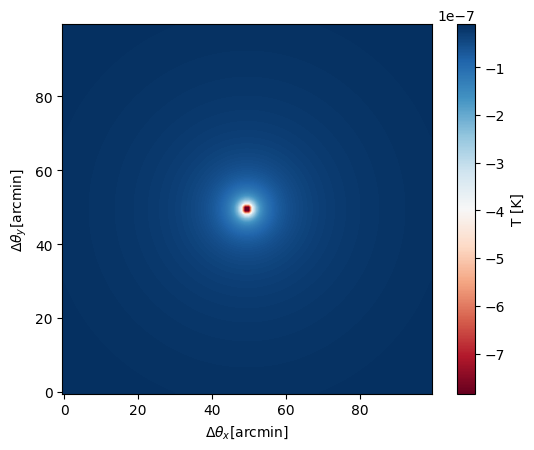

In [37]:
testLens1 = lens_profile()


## setting rSpace
 
#print(testLens1.r_max)
#print(testLens1.rSpace)
#testLens1.set_rMax(100)
#estLens1.set_rSpace()
#print(testLens1.rSpace)
#print(testLens1.r_max)

testLens1._calc_hubble_parameter()
testLens1._calc_comoving_dist()
#testLens1._calc_r_x()
#testLens1._calc_c_x()
#testLens1._calc_rho_crit()
testLens1._calc_density_parameter()
#testLens1._calc_scale_radius()
#testLens1.rho_lens()
#testLens1.M_NFW()
#testLens1.set_angle_map(1, 3)
#testLens1._calc_lambda()
#testLens1._calc_f()
#testLens1._calc_v_max()
testLens1.delta_theta()
testLens1.plot_d_theta()

In [38]:
testLens1.d_theta.shape

(100, 100)

In [13]:
testLens1.pos_map.shape

(2, 100, 100)

In [7]:
testLens1.comoving_dist

# lensing

## code

In [39]:
class lensing():
    def __init__(self, map_size: float = None, pixel_size: float = None, pixel_number: int = None, dec_shift = 0, asc_shift = 0, pre_lens_map: list[list[float]] = None, poly_degree = 2):
        self.map_size = map_size
        self.pixel_size = pixel_size
        self.pixel_number = pixel_number
        self.dec_shift = dec_shift
        self.asc_shift = asc_shift
        self.pre_lens_map = pre_lens_map
        self.l_total = poly_degree
        ## internal vatiables
        self.pos_map = None
        self.pos_map_fs = None
        self.lensing_map = None
        ## output
        self.post_lensing_map = None

    
    def set_NFW_variables(self) -> None:
        return None
    
    def make_NFW_profile(self) -> None:
        return None
    
    def set_map_parameters(self, map_size: float = None, pixel_size: float = None, pixel_number: int = None) -> None:
        if map_size is not None:
            self.map_size = map_size
        if pixel_size is not None:
            self.pixel_size = pixel_size
        if pixel_number is not None:
            self.pixel_number = pixel_number
        else:
            self.pixel_number = self.map_size*(60/self.pixel_size)
        if not all((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing map_variables.")
            return False
        else:
            print("Full set of map variables defined.")
            return True
    
    def make_lensing_map():
        return None
    
    def set_pre_lens_map(self, map: list[list[float]]) -> None:
        self.pre_lens_map = map
        return None
    
    def copy_map_parameters(self):
        if not (self.pre_lens_map).any():
            print("!!!!!!!!!!!!!!!!! Please first provide a pre lens map.")
        elif ((self.pre_lens_map).shape[0] != (self.pre_lens_map).shape[1]):
            print("!!!!!!!!!!Please provide squared map.")
        else:
            self.pixel_number = (self.pre_lens_map).shape[0]
            self.pixel_size = 1                                     ######### Temporary solution
            self.map_size = self.pixel_number                       ######### Temporary solution
            print("Map parameters: map_size = " + str(self.map_size) + ", pixel_size = " + str(self.pixel_size) + ", pixel_number = " + str(self.pixel_number) + ".")
        return None
    
    # def _make_background_map(self) -> list[list[list[float]], float]:
    #     mean = np.mean(self.pre_lens_map)
    #     bg_map = np.ones((self.pixel_number, self.pixel_number))*mean
    #     self.background_map = bg_map
    #     return bg_map, mean
    
    def _make_pos_map(self, shift_dec = 0, shift_asc = 0):
        # real_space
        dec, asc = np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number), np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number)
        pos_map = np.meshgrid(dec, asc)
        ## Necessary because tuples can only be read (not modified)
        pos_map_obj_1, pos_map_obj_2 = pos_map 
        pos_map_obj_1 += shift_dec
        pos_map_obj_2 += shift_asc
        self.pos_map =  pos_map_obj_1, pos_map_obj_2

        # fourier_space
        x, y = 2*np.pi*np.fft.fftfreq(self.pixel_number, (np.pi*180)*self.pixel_size/60), 2*np.pi*np.fft.fftfreq(self.pixel_number, (np.pi*180)*self.pixel_size/60)  ## pixel_size given in seconds
        self.pos_map_fs = np.meshgrid(x, y)
        return None
    
    def _make_pos_map_test(self, shift_dec = 0, shift_asc = 0) -> None:
        # real_space
        dec, asc = np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number), np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number)
        pos_map = np.meshgrid(dec, asc)
        ## Necessary because tuples can only be read (not modified)
        pos_map_obj_1, pos_map_obj_2 = pos_map
        pos_map_obj_1 += shift_dec
        pos_map_obj_2 += shift_asc
        self.pos_map =  pos_map_obj_1, pos_map_obj_2

        # fourier_space
        self.pos_map_fs = np.fft.fft2(self.pos_map)

        return None
    
    def apply_lensing(self, pre_lens_map = None, shift_dec = 0, shift_asc = 0):
        if pre_lens_map:
            self.pre_lens_map = pre_lens_map

        self._make_pos_map(shift_dec, shift_asc)
        dec_pos, asc_pos = self.pos_map
        post_lensing_dec_pos, post_lensing_asc_pos = dec_pos + self.lensing_map[0], asc_pos + self.lensing_map[1]
        interpolate = scipy.interpolate.RectBivariateSpline(asc_pos[:,0], dec_pos[0,:], self.pre_lens_map, kx = self.l_total, ky = self.l_total)
        print(interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()))
        print(interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()).reshape([len(asc_pos), len(dec_pos)]))
        self.post_lensing_map  = interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()).reshape([len(asc_pos), len(dec_pos)]) 

        return None
    
    def get_lensed_map(self) -> list[list[float]]:
        return self.post_lensing_map
    
    def plot_lensed_map():
        return None

In [40]:
cmb = np.array([[0, 1, 1], [1, 1, 0], [2, 0, 1]])
cmb_lensing = np.array([[3, 0, -3], [3, 0, -3], [3, 0, -3]]), np.array([[3, 3, 3], [0, 0, 0], [-3, -3, -3]])

#cmb = np.array([[0, 0, 0, 1, 1], [0, 0, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
#cmb_lensing = np.array([[5, 3, 0, -3, -5],[5, 3, 0, -3, -5], [5, 3, 0, -3, -5], [5, 3, 0, -3, -5], [5, 3, 0, -3, -5]]), np.array([[-5, -5, -5, -5, -5], [-3, -3, -3, -3, -3], [0, 0, 0, 0, 0], [3, 3, 3, 3, 3], [5, 5, 5, 5, 5]])*(-1)

#cmb = np.random.rand(101, 101)
#x_spiegel = np.linspace(-100, 100, 101)
#y_spiegel = np.linspace(-100, 100, 101)
#cmb_lensing = x_spiegel, y_spiegel




lensTest1 = lensing(pre_lens_map=cmb)
lensTest1.lensing_map = cmb_lensing

#lensTest1.set_map_parameters(10, 1, 10)
lensTest1.copy_map_parameters()

Map parameters: map_size = 3, pixel_size = 1, pixel_number = 3.


In [41]:
lensTest1._make_pos_map()
lensTest1.apply_lensing()
#lensTest1.get_lensed_map()

[1. 0. 2. 0. 1. 1. 1. 1. 0.]
[[1. 0. 2.]
 [0. 1. 1.]
 [1. 1. 0.]]


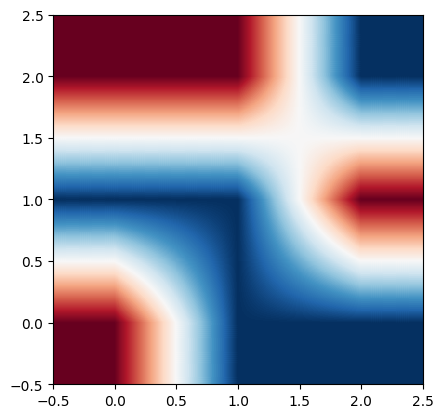

In [35]:
im2 = plt.imshow(cmb, origin='lower', interpolation='bilinear', cmap='RdBu')
im2.set_clim()

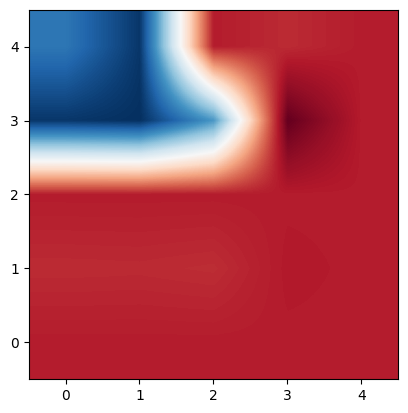

In [42]:
im2 = plt.imshow(lensTest1.get_lensed_map(), origin='lower', interpolation='bilinear', cmap='RdBu')
im2.set_clim()

In [25]:
x_spiegel = np.linspace(-100, 100, 101)
#x_spiegel[0:50] = x_spiegel[0:50]-1
y_spiegel = np.linspace(-100, 100, 101)
spiegel = np.meshgrid(x_spiegel, y_spiegel)
spiegel

(array([[-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        ...,
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.]], shape=(101, 101)),
 array([[-100., -100., -100., ..., -100., -100., -100.],
        [ -98.,  -98.,  -98., ...,  -98.,  -98.,  -98.],
        [ -96.,  -96.,  -96., ...,  -96.,  -96.,  -96.],
        ...,
        [  96.,   96.,   96., ...,   96.,   96.,   96.],
        [  98.,   98.,   98., ...,   98.,   98.,   98.],
        [ 100.,  100.,  100., ...,  100.,  100.,  100.]], shape=(101, 101)))

In [8]:
cmb

array([[0.88209546, 0.58144781, 0.96147407, ..., 0.89275294, 0.20781482,
        0.16829575],
       [0.23936019, 0.68616057, 0.46952962, ..., 0.60284743, 0.80208226,
        0.10541345],
       [0.28077568, 0.43644544, 0.32167395, ..., 0.11679424, 0.37198256,
        0.08222438],
       ...,
       [0.78069873, 0.55273555, 0.44812325, ..., 0.47573144, 0.87367432,
        0.46137952],
       [0.823493  , 0.12594808, 0.05810748, ..., 0.28283685, 0.07433936,
        0.20595412],
       [0.83080826, 0.43798354, 0.78109664, ..., 0.14108825, 0.98697004,
        0.49385929]], shape=(100, 100))

## class

# Full runs

## Awais

Full set of map variables defined.
Map Size: 120
Pixel Size: 0.2
Number of Pixel: 600.0
coordinates made.
##############################
5.817764173314432e-05
tttttttttttttttttttttttttttttt
[[-1.         -0.9966611  -0.9933222  -0.98998331 -0.98664441 -0.98330551
  -0.97996661 -0.97662771 -0.97328881 -0.96994992 -0.96661102 -0.96327212
  -0.95993322 -0.95659432 -0.95325543 -0.94991653 -0.94657763 -0.94323873
  -0.93989983 -0.93656093 -0.93322204 -0.92988314 -0.92654424 -0.92320534
  -0.91986644 -0.91652755 -0.91318865 -0.90984975 -0.90651085 -0.90317195
  -0.89983306 -0.89649416 -0.89315526 -0.88981636 -0.88647746 -0.88313856
  -0.87979967 -0.87646077 -0.87312187 -0.86978297 -0.86644407 -0.86310518
  -0.85976628 -0.85642738 -0.85308848 -0.84974958 -0.84641068 -0.84307179
  -0.83973289 -0.83639399 -0.83305509 -0.82971619 -0.8263773  -0.8230384
  -0.8196995  -0.8163606  -0.8130217  -0.8096828  -0.80634391 -0.80300501
  -0.79966611 -0.79632721 -0.79298831 -0.78964942 -0.78631052 -0.782971

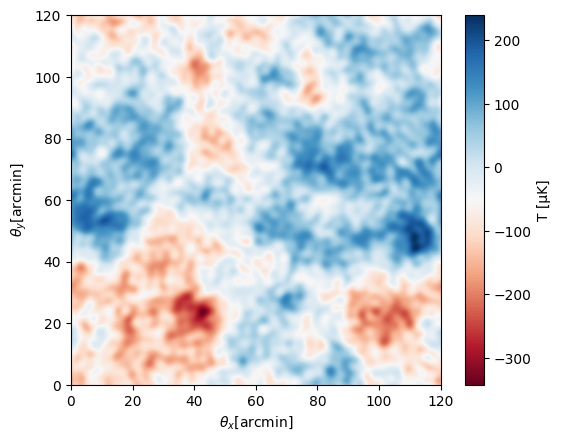

In [3]:
background = map_maker(map_size=120, pixel_size=0.2, l_degrees=6000)

background_map_fs, background_map, background_map_real = background.make_gaussian_random_field(zero_dipole=False, spectrum_type = "acoustic")
background.plot_gaussian_random_field()
print("RMS = " + str(background.rms_estimation()))

In [4]:
lens = lens_profile(120, 600)
lens.delta_theta()
#lensing_map_x, lensing_map_y = lens.lensing_map()
lensing_map = lens.lensing_map()
#lens.plot_d_theta()

cluster mass 500000000000000.0
cluster redshift z: 0.7
speed of light: 299792458.0
scaled hubble constant: 0.6774
omega_m: 0.3089
omega_l: 0.6911
cosmology: planck18
############################################
pos map set!
comoving_dist = 118335265.85625775
Cosmology set as planck18
c_x = 3.7827364915269097
hubble parameter = 0.42761918093611
r_x = 0.4232334236845668
scale radius r_s: 0.11188551585144323
rho_crit = 5074992.385931871
density_parameter: 6262242483.93626
v_max calculated!
lambda calculated!
f calculated!
redshift z changed to: 1100.0
comoving_dist = 641244557.6862361
redshift z changed to: 1100.0
comoving_dist = 641244557.6862361
##############################################
angular displacement calculated!
##############################################
Map of lensing angles created!
##############################################
Done!


In [8]:
# im = plt.imshow(lensing_map_y, origin='lower', interpolation='bilinear', cmap='RdBu')
# im.set_clim()

# plt.xlabel(r"$\theta_x$[arcmin]")
# plt.ylabel(r"$\theta_y$[arcmin]")


# cbar = plt.colorbar(im)
# cbar.set_label("T [K]")   # label for the scale

In [5]:
#lensing_map = np.array([lensing_map_x, lensing_map_y])

output = lensing(pre_lens_map=background_map_real, lens = lensing_map)
output.lensing_map = lensing_map

output.copy_map_parameters()
output._make_pos_map()

output.apply_lensing()
#lensTest1.get_lensed_map()

Map parameters: map_size = 600, pixel_size = 1, pixel_number = 600.


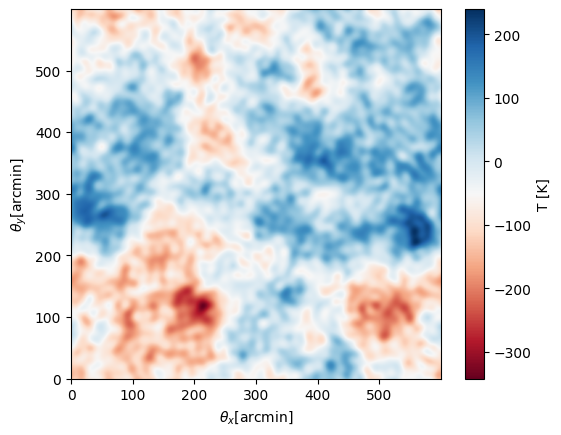

In [6]:
im1 = plt.imshow(output.get_lensed_map(), origin='lower', interpolation='bilinear', cmap='RdBu')
im1.set_clim()

plt.xlabel(r"$\theta_x$[arcmin]")
plt.ylabel(r"$\theta_y$[arcmin]")


cbar = plt.colorbar(im1)
cbar.set_label("T [K]")   # label for the scale

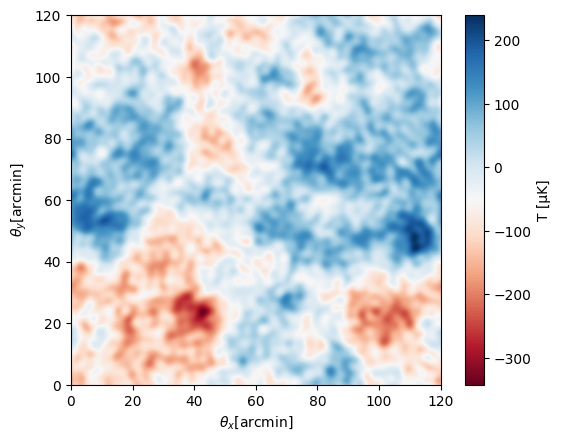

In [7]:
background.plot_gaussian_random_field()

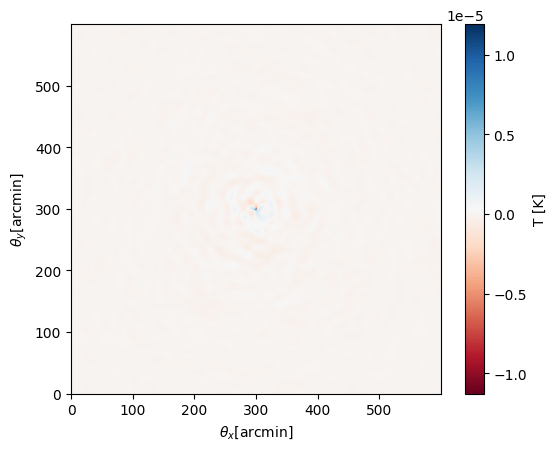

In [9]:
#im = plt.imshow(output.get_lensed_map()-background_map_real, origin='lower', interpolation='bilinear', cmap='RdBu', norm = matplotlib.colors.LogNorm())
im = plt.imshow(output.get_lensed_map()-background_map_real, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim()

plt.xlabel(r"$\theta_x$[arcmin]")
plt.ylabel(r"$\theta_y$[arcmin]")

cbar = plt.colorbar(im)
cbar.set_label("T [K]")   # label for the scale

In [48]:
# Assume `lens.d_theta` is your radial deflection map
# and `output.pos_map` contains the meshgrid: (dec_pos, asc_pos)

dec_pos, asc_pos = output.pos_map  # rows, columns

# Compute radius from center for each pixel
r = np.sqrt(dec_pos**2 + asc_pos**2) + 1e-12  # add small number to avoid divide by zero

# Convert radial deflection into x and y components
alpha_x = lens.d_theta * (asc_pos / r)  # deflection along asc (x)
alpha_y = lens.d_theta * (dec_pos / r)  # deflection along dec (y)

# Create tuple expected by your lensing class
lensing_map = (alpha_y, alpha_x)  # check: first = dec, second = asc

# Assign to the lensing object
output.lensing_map = lensing_map

# Apply lensing
output.apply_lensing()

# Subtract background to see the ring structure
ring_map = output.get_lensed_map() - background_map_real

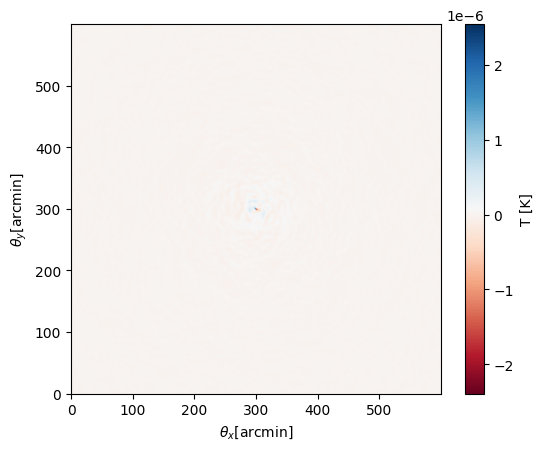

In [49]:
im3 = plt.imshow(ring_map, origin='lower', interpolation='bilinear', cmap='RdBu')
im3.set_clim()

plt.xlabel(r"$\theta_x$[arcmin]")
plt.ylabel(r"$\theta_y$[arcmin]")

cbar = plt.colorbar(im3)
cbar.set_label("T [K]")   # label for the scale

## Kausuv 

Full set of map variables defined.
Map Size: 120
Pixel Size: 0.2
Number of Pixel: 600.0
coordinates made.
##############################
5.817764173314432e-05
tttttttttttttttttttttttttttttt
[[-1.         -0.9966611  -0.9933222  -0.98998331 -0.98664441 -0.98330551
  -0.97996661 -0.97662771 -0.97328881 -0.96994992 -0.96661102 -0.96327212
  -0.95993322 -0.95659432 -0.95325543 -0.94991653 -0.94657763 -0.94323873
  -0.93989983 -0.93656093 -0.93322204 -0.92988314 -0.92654424 -0.92320534
  -0.91986644 -0.91652755 -0.91318865 -0.90984975 -0.90651085 -0.90317195
  -0.89983306 -0.89649416 -0.89315526 -0.88981636 -0.88647746 -0.88313856
  -0.87979967 -0.87646077 -0.87312187 -0.86978297 -0.86644407 -0.86310518
  -0.85976628 -0.85642738 -0.85308848 -0.84974958 -0.84641068 -0.84307179
  -0.83973289 -0.83639399 -0.83305509 -0.82971619 -0.8263773  -0.8230384
  -0.8196995  -0.8163606  -0.8130217  -0.8096828  -0.80634391 -0.80300501
  -0.79966611 -0.79632721 -0.79298831 -0.78964942 -0.78631052 -0.782971

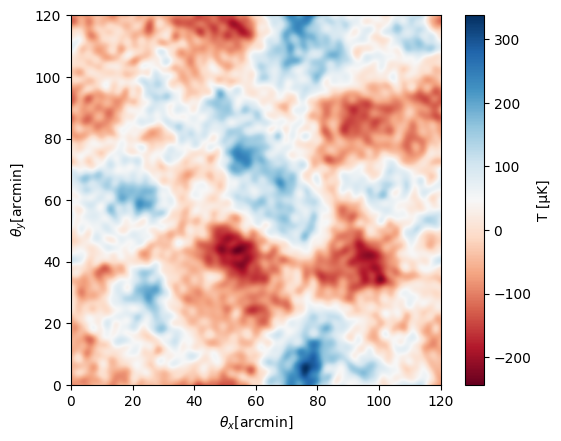

In [6]:
background = map_maker(map_size=120, pixel_size=0.2, l_degrees=6000)

background_map_fs, background_map, background_map_real = background.make_gaussian_random_field(zero_dipole=False, spectrum_type = "acoustic")
background.plot_gaussian_random_field()
print("RMS = " + str(background.rms_estimation()))

In [7]:
from codes.map_creation import nfw_lens
h = 0.6774
omega_m = 0.3089
lens = nfw_lens(cosmology = FlatLambdaCDM(H0=h*100., Om0=omega_m))

In [8]:
lens.make_map(120, 0.2)
lens._calc_angular_seperation()
lens._calc_ref_density()
lens._calc_virial_r()
cosmo.setCosmology("planck18")
lens._calc_concentration()
lens._calc_nfwConcentration()
lens._calc_nfwScaleRadius()
lens._calc_lensing_distances()
lens._calc_crit_surface_density()
lens._calc_pyhsical_dist()
lens._calc_nfwProfile()
lens.proj_surf_density()
lens.kappa()
lens._make_multipole_magnitude_2d()
lens.kappa2alpha()

alpha = np.array([lens.alphaX, lens.alphaY])

600
120
77777777777777777777777777777777777
[[ 0.00014016  0.00042037  0.00070034 ... -0.00070034 -0.00042037
  -0.00014016]
 [ 0.00014018  0.0004204   0.0007004  ... -0.0007004  -0.0004204
  -0.00014018]
 [ 0.0001402   0.00042048  0.00070052 ... -0.00070052 -0.00042048
  -0.0001402 ]
 ...
 [ 0.0001402   0.00042048  0.00070052 ... -0.00070052 -0.00042048
  -0.0001402 ]
 [ 0.00014018  0.0004204   0.0007004  ... -0.0007004  -0.0004204
  -0.00014018]
 [ 0.00014016  0.00042037  0.00070034 ... -0.00070034 -0.00042037
  -0.00014016]]


In [9]:
output = lensing(pre_lens_map=background_map_real, lens = alpha)
output.lensing_map = alpha

output.copy_map_parameters()
output._make_pos_map()

output.apply_lensing()

Map parameters: map_size = 600, pixel_size = 1, pixel_number = 600.


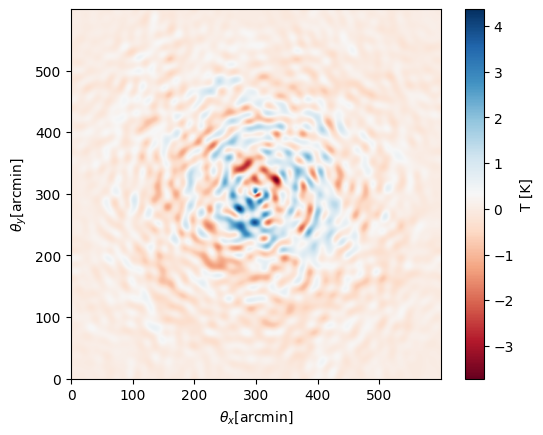

In [10]:
#im = plt.imshow(output.get_lensed_map()-background_map_real, origin='lower', interpolation='bilinear', cmap='RdBu', norm = matplotlib.colors.LogNorm())
im = plt.imshow(output.get_lensed_map()-background_map_real, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim()

plt.xlabel(r"$\theta_x$[arcmin]")
plt.ylabel(r"$\theta_y$[arcmin]")

cbar = plt.colorbar(im)
cbar.set_label("T [K]")   # label for the scale

# Other

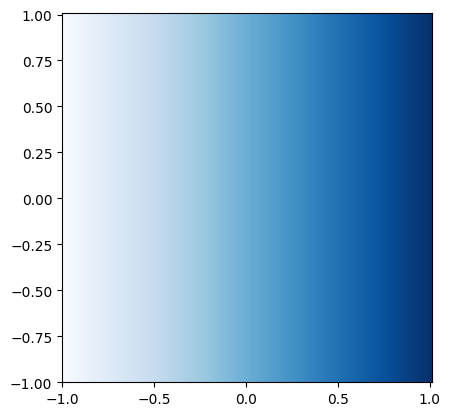

In [9]:
plt.imshow(X, cmap = 'Blues', extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])

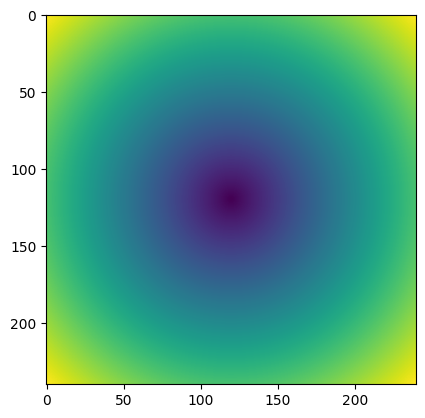

In [15]:
plt.imshow(R)

In [11]:
X

array([[-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       ...,
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ]])

In [13]:
Y

array([[-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       [-0.9916318, -0.9916318, -0.9916318, ..., -0.9916318, -0.9916318,
        -0.9916318],
       [-0.9832636, -0.9832636, -0.9832636, ..., -0.9832636, -0.9832636,
        -0.9832636],
       ...,
       [ 0.9832636,  0.9832636,  0.9832636, ...,  0.9832636,  0.9832636,
         0.9832636],
       [ 0.9916318,  0.9916318,  0.9916318, ...,  0.9916318,  0.9916318,
         0.9916318],
       [ 1.       ,  1.       ,  1.       , ...,  1.       ,  1.       ,
         1.       ]])